In [55]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAXResults
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.gofplots import ProbPlot
from statsmodels.tsa.api import ExponentialSmoothing
from scipy.stats import shapiro
from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima.utils import ndiffs

### Traitement du jeu de données exporté du site de RTE, Réseau de transport d'électricité

In [56]:
data = pd.read_csv('energie.csv', sep=';', encoding='cp1252')
data.head(10)

,Mois,Qualité,Territoire,Production totale,Production nucléaire,Production thermique totale,Production thermique charbon,Production thermique fioul,Production thermique gaz,Production hydraulique,...,Production bioénergies,Consommation totale,Solde exportateur,Echanges export,Echanges import,Echanges avec le Royaume-Uni,Echanges avec l'Espagne,Echanges avec l'Italie,Echanges avec la Suisse,Echanges avec l'Allemagne et la Belgique
0,2012-01,Données définitives,France,57177,42811.0,5399,741.0,691,3967,6741,...,514,51086,5371.0,7043.0,1672.0,929.0,724.0,1581.0,2195.0,-59.0
1,2012-02,Données définitives,France,54419,38661.0,8721,2511.0,1309,4901,5244,...,454,54476,-715.0,4504.0,5220.0,-798.0,-309.0,1244.0,1579.0,-2430.0
2,2012-03,Données définitives,France,48583,37549.0,5276,1435.0,666,3175,3894,...,531,43156,4888.0,7042.0,2153.0,583.0,330.0,1742.0,2235.0,-1.0
3,2012-04,Données définitives,France,44192,33100.0,3484,1655.0,486,1343,5302,...,405,40176,3447.0,5762.0,2314.0,547.0,-9.0,1271.0,1670.0,-31.0
4,2012-05,Données définitives,France,40433,29058.0,1772,854.0,368,549,7706,...,469,35257,4425.0,6391.0,1965.0,693.0,251.0,1341.0,1060.0,1079.0
5,2012-06,Données définitives,France,37518,26562.0,2219,960.0,384,875,6823,...,437,33219,3648.0,5674.0,2026.0,447.0,482.0,1207.0,599.0,913.0
6,2012-07,Données définitives,France,37910,28818.0,2221,1110.0,437,674,4901,...,513,34141,3216.0,5327.0,2110.0,822.0,494.0,825.0,787.0,287.0
7,2012-08,Données définitives,France,36339,28314.0,2533,1165.0,413,956,3563,...,486,32247,3561.0,5834.0,2273.0,948.0,334.0,610.0,792.0,877.0
8,2012-09,Données définitives,France,38035,30130.0,2450,1382.0,396,671,3641,...,470,33269,4054.0,6036.0,1981.0,1011.0,72.0,790.0,1413.0,769.0
9,2012-10,Données définitives,France,42987,32848.0,3518,2039.0,456,1022,4534,...,450,38628,3625.0,6387.0,2762.0,183.0,-273.0,1621.0,1774.0,321.0


In [57]:
conso = data[['Mois', 'Territoire', 'Consommation totale']]
conso = conso[conso['Territoire'] == 'France']
conso.drop('Territoire', axis=1, inplace=True)
conso.rename(columns={'Mois': 'mois'}, inplace=True)
conso

,mois,Consommation totale
0,2012-01,51086
1,2012-02,54476
2,2012-03,43156
3,2012-04,40176
4,2012-05,35257
...,...,...
1344,2021-07,32959
1357,2021-08,31184
1370,2021-09,32350
1383,2021-10,36762


In [58]:
#Changement du type de Series en datetime
#Changement d'index pour que la série temporelle soit reconnue
conso['mois'] = pd.to_datetime(conso['mois'])
conso.set_index('mois', inplace=True)

In [59]:
conso

,Consommation totale
mois,
2012-01-01,51086
2012-02-01,54476
2012-03-01,43156
2012-04-01,40176
2012-05-01,35257
...,...
2021-07-01,32959
2021-08-01,31184
2021-09-01,32350


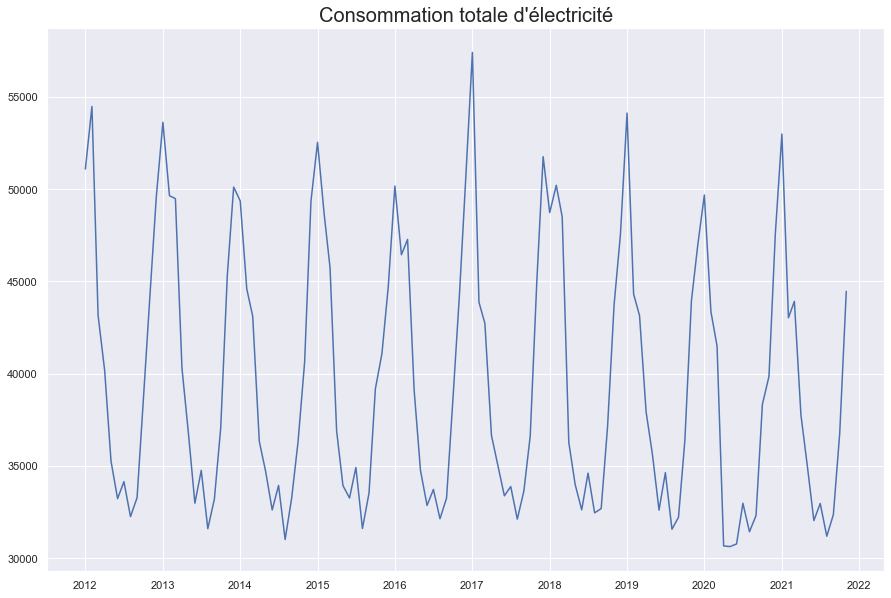

In [60]:
#Visualisation de la consommation totale d'électricité en énergie 
plt.figure(figsize=(15, 10))
plt.plot(conso['Consommation totale'])
plt.title("Consommation totale d'électricité", fontsize=20)
plt.savefig("p9_graphic/conso_elect.png")
plt.show()

### Dans la série temporelle ci-dessus nous pouvons constater des cycles réguliers et de même amplitude au fil du temps. Nous effectuerons une correction des données de consommation mensuelles de l'effet température (dues au chauffage électrique) à l’aide de la régression linéaire. Il est donc nécessaire d'extraire les données propres au chauffage électrique sur la même période.

In [61]:
#Récapitulatif des consommations annuelles
conso_y = conso.resample('Y').sum()

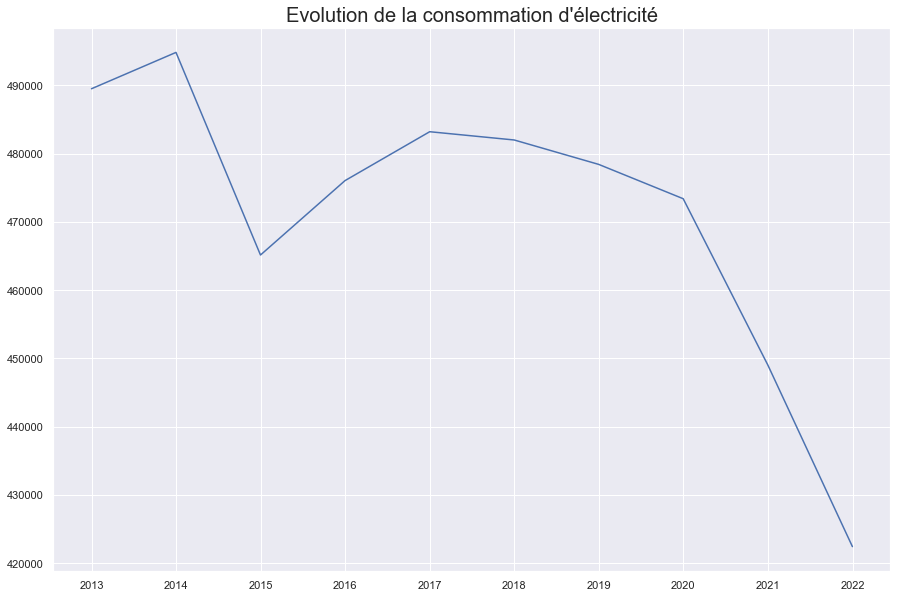

In [62]:
plt.figure(figsize=(15, 10))
plt.plot(conso_y['Consommation totale'])
plt.title("Evolution de la consommation d'électricité", fontsize=20)
plt.savefig("p9_graphic/conso_evo.png")
plt.show()

### Ce graphique nous donne un bref aperçu de l'évolution de la consommation électrique en France. Nous remarquons que l'année 2013 a été la plus demandeuse en énergie. La baisse de consommation observée à partir de l'année 2020 peut être expliquée par la crise sanitaire qu'a connu la France.

### Traitement du jeu de données exporté du site Cegibat, l'expertise efficacité énergétique de GRDF

In [63]:
dju_df = pd.read_csv('dju.csv', header=None, skiprows=11, encoding='cp1252')

In [64]:
dju_df.drop([0, 1], axis=0, inplace=True)
dju_df.drop([13], axis=1, inplace=True)

In [65]:
dju_df[0] = dju_df[0].astype(int)
dju_df.set_index([0], inplace=True)

In [66]:
for j in dju_df.columns:
    dju_df[j] = dju_df[j].str.replace(',','.')
    dju_df[j] = dju_df[j].astype(float)

In [67]:
dju_df

,1,2,3,4,5,6,7,8,9,10,11,12
0,,,,,,,,,,,,
2020,339.0,249.6,268.6,81.4,65.7,20.6,0.9,4.5,34.3,157.5,227.2,336.8
2019,404.9,268.3,233.1,168.5,117.9,24.4,0.0,1.7,26.7,133.7,282.6,327.3
2018,303.4,432.6,314.3,119.7,55.9,8.1,0.0,3.3,34.3,122.4,282.5,325.9
2017,467.9,278.4,206.1,182.6,75.0,9.4,1.0,6.8,62.6,99.4,282.6,369.0
2016,364.4,321.6,321.1,212.1,88.1,27.5,5.7,3.2,11.7,176.0,285.6,390.8
2015,392.0,365.7,275.5,141.1,91.5,15.8,6.9,6.1,71.9,176.9,195.0,248.1
2014,324.4,281.9,223.9,135.5,100.2,19.1,8.3,19.3,16.0,92.3,222.6,368.2
2013,429.2,402.2,376.6,209.5,158.4,43.6,0.6,5.0,41.5,105.0,303.9,349.5
2012,336.0,435.9,201.9,230.3,83.3,35.0,12.4,2.4,58.0,154.6,296.2,345.9


In [68]:
dju = {'mois':[],'dju_chauffage':[]}

for year in dju_df.index.values:
    for month in dju_df.columns:
        dju['mois'].append(f"{year}-{month}")
        dju['dju_chauffage'].append(dju_df.loc[year,month])
        
dju = pd.DataFrame(dju)
dju['mois'] = pd.to_datetime(dju['mois'])

In [69]:
dju.set_index('mois', inplace=True)

In [70]:
dju

,dju_chauffage
mois,
2020-01-01,339.0
2020-02-01,249.6
2020-03-01,268.6
2020-04-01,81.4
2020-05-01,65.7
...,...
2009-08-01,0.9
2009-09-01,26.9
2009-10-01,149.6


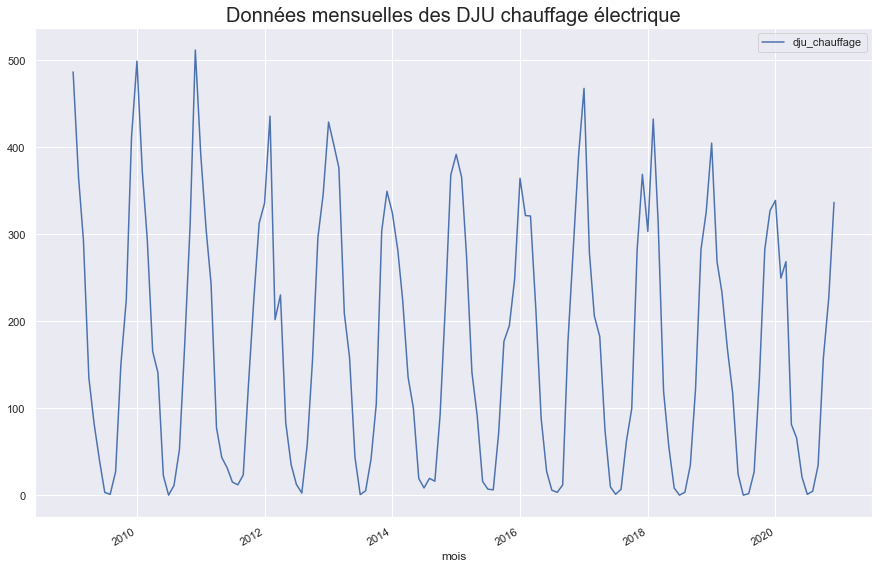

In [71]:
#Visualisation des données mensuelles des Degrés Jour Unifiés (DJU) chauffage électrique
dju.plot(figsize=(15, 10))
plt.title("Données mensuelles des DJU chauffage électrique", fontsize=20)
plt.savefig("p9_graphic/dju_chauffage.png")
plt.show()

### Naturellement, cette série temporelle dépend de la température extérieure au fil du temps. Ainsi, les besoins de chauffage évoluent au fil des saisons.

In [72]:
df = pd.merge(conso, dju, how='inner', on='mois')
df.rename(columns={'Consommation totale':'consommation'}, inplace=True)
df

,consommation,dju_chauffage
mois,,
2012-01-01,51086,336.0
2012-02-01,54476,435.9
2012-03-01,43156,201.9
2012-04-01,40176,230.3
2012-05-01,35257,83.3
...,...,...
2020-08-01,31428,4.5
2020-09-01,32307,34.3
2020-10-01,38332,157.5


In [73]:
df.isna().any()

consommation     False
dju_chauffage    False
dtype: bool

In [74]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
consommation,108.0,39737.250000,7086.595702,30622.0,33347.75,37082.50,45047.50,57406.0
dju_chauffage,108.0,170.752778,140.657776,0.0,27.30,156.05,288.25,467.9


### Nous avons désormais notre échantillon de travail. Nous allons à présent corriger ces données de la consommation en électricité de l'effet température causé par le chauffage à l'aide de la régression linéaire.

### Correction des données de consommation mensuelle de l'effet température

In [75]:
reg = smf.ols('consommation ~ dju_chauffage', data=df).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:           consommation   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     1860.
Date:                Fri, 27 May 2022   Prob (F-statistic):           4.75e-69
Time:                        00:36:20   Log-Likelihood:                -952.56
No. Observations:                 108   AIC:                             1909.
Df Residuals:                     106   BIC:                             1914.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      3.137e+04    250.876    125.040

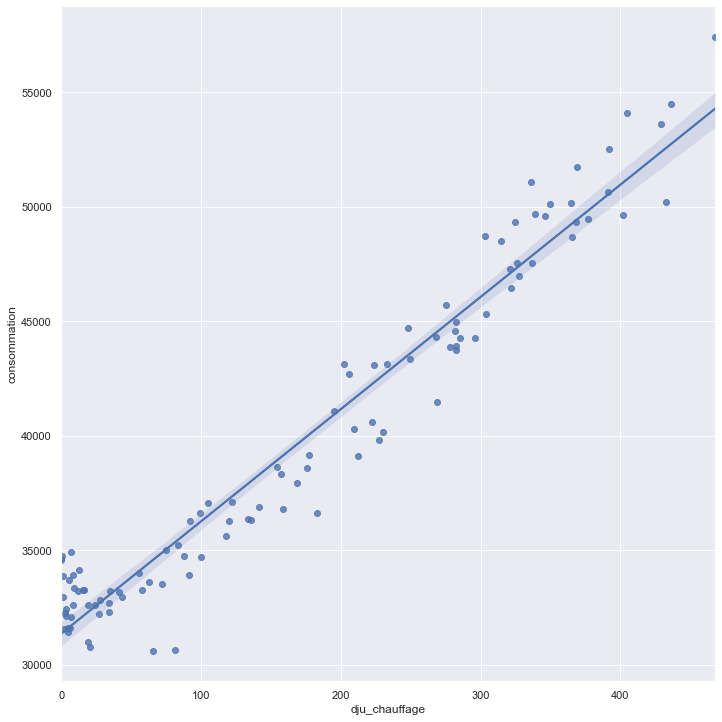

In [76]:
sns.lmplot(x="dju_chauffage", y="consommation", data=df, height=10)
plt.savefig("p9_graphic/regression.png")
plt.show()

In [77]:
coef_dju = reg.params['dju_chauffage']
coef_dju

49.00508891055377

In [78]:
#Calcul de la correction 
df['conso_corr'] = df['consommation'] - df['dju_chauffage']*coef_dju

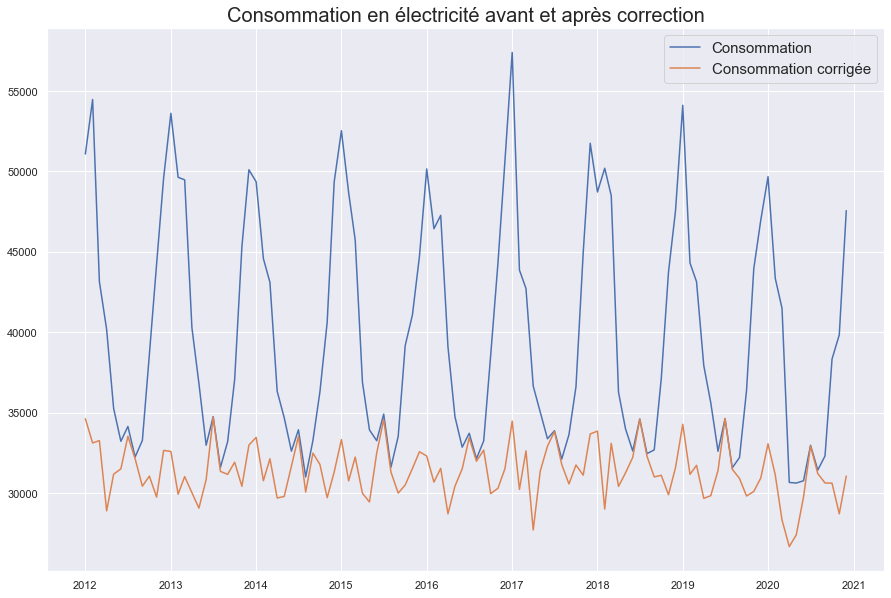

In [79]:
#Visualisation de la consommation en électricité avant et après correction
plt.figure(figsize=(15,10))
plt.plot(df['consommation'], label='Consommation')
plt.plot(df['conso_corr'], label='Consommation corrigée')
plt.title('Consommation en électricité avant et après correction', fontsize=20)
plt.legend(fontsize=15)
plt.savefig("p9_graphic/conso_corr.png")

plt.show()

### Désaisonnalisation de la consommation obtenue après correction, en utilisant les moyennes mobiles

In [80]:
decomp = seasonal_decompose(df['conso_corr'], model='additive')

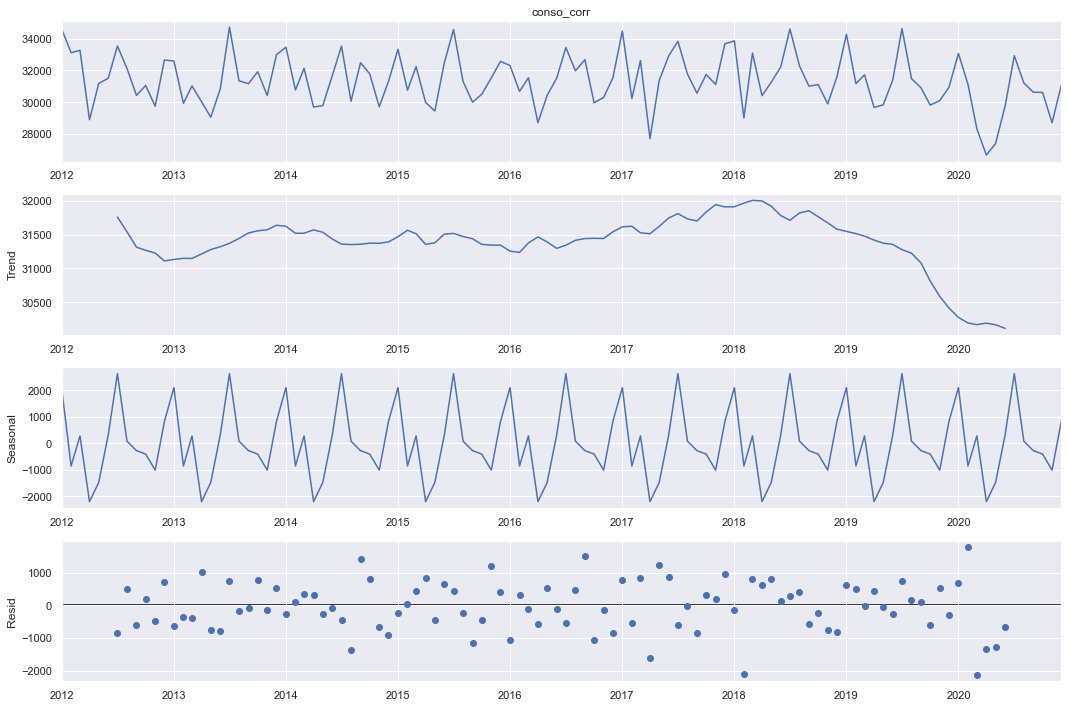

In [81]:
sns.set(rc={"figure.figsize":(15, 10)})
decomp.plot()
plt.savefig('p9_graphic/decomposition.jpg')
plt.show()

In [82]:
#Différence avec la saisonnalité pour obtenir une série indépendante de l'impact saisonnier
df['conso_cd'] = df['conso_corr'] - decomp.seasonal

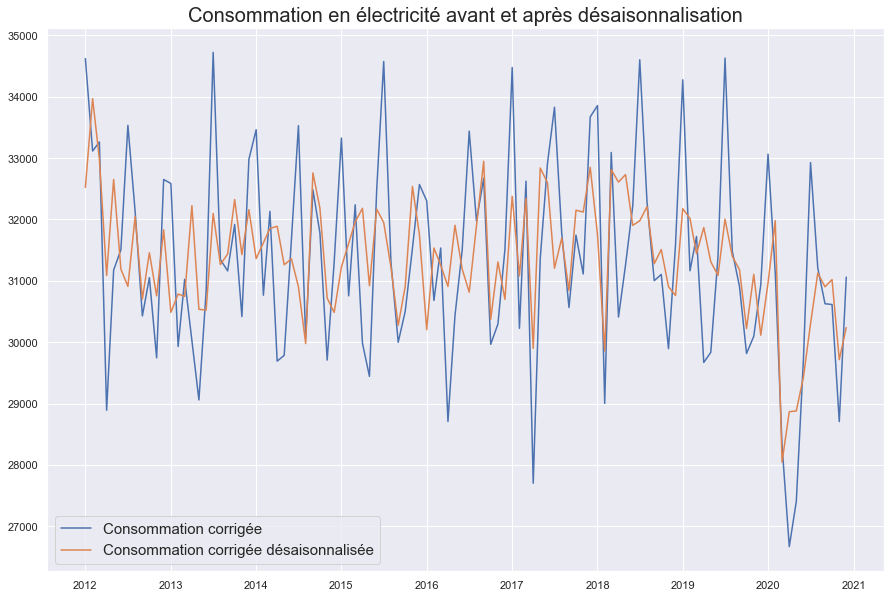

In [83]:
#Visualisation de la consommation en électricité avant et après désaisonnalisation
plt.figure(figsize=(15,10))
plt.plot(df['conso_corr'], label='Consommation corrigée')
plt.plot(df['conso_cd'], label='Consommation corrigée désaisonnalisée')
plt.title('Consommation en électricité avant et après désaisonnalisation', fontsize=20)
plt.savefig("p9_graphic/conso_cd.png")
plt.legend(fontsize=15)
plt.show()

### Prévision de la consommation (corrigée de l'effet température) sur un an

#### Nous utiliserons la méthode de Holt-Winters (lissage exponentiel) puis la méthode SARIMA

### Prévision par la méthode Holt-Winters

In [84]:
y = np.asarray(df['conso_corr'])
es = ExponentialSmoothing(y, seasonal_periods=12, trend='add', seasonal='add').fit()
es_pred = es.forecast(12)

C:\Users\denis\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Users\denis\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


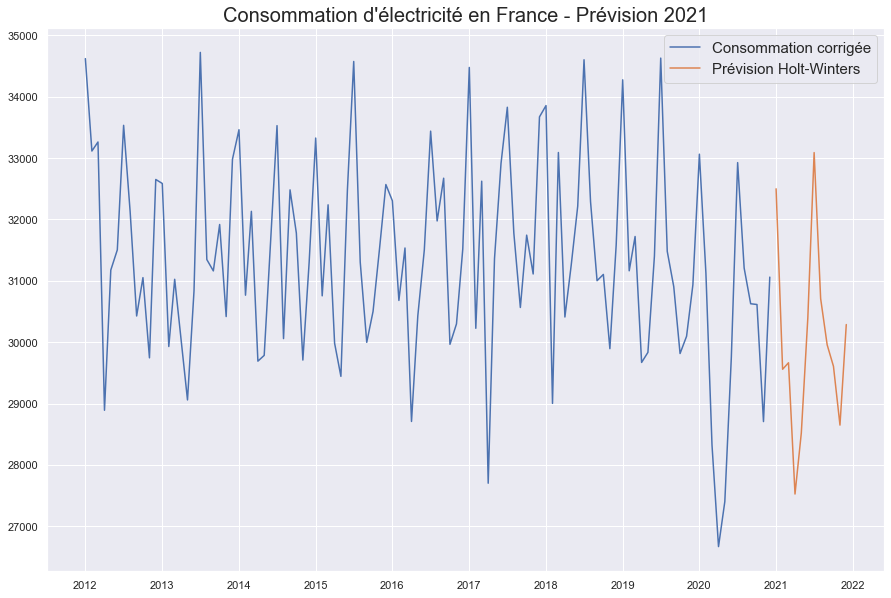

In [85]:
#Visualisation de la prévision à 12 mois par Holt-Winters
plt.plot(df["conso_corr"], label='Consommation corrigée')
plt.plot(pd.date_range(df.index[len(y)-1], periods=12, freq='M'), es_pred, label='Prévision Holt-Winters')

plt.title("Consommation d'électricité en France - Prévision 2021", fontsize=20)

plt.savefig("p9_graphic/prevision2021_holt-winters.png")
plt.legend(fontsize=15)
plt.show()

### La prévision par Holt-Winters prend en compte la saisonnalité. Nous allons tester ensuite la qualité de prédiction du modèle, en tronquant la série de l'année 2020 que nous allons prédire puis comparer avec les valeurs réelles.

C:\Users\denis\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\denis\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Users\denis\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


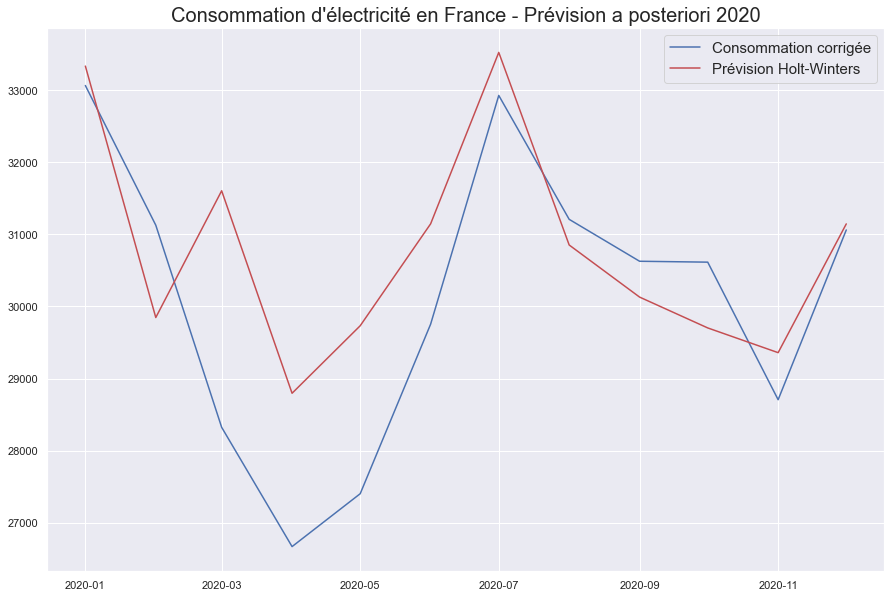

In [90]:
y = df[:'2019']['conso_corr']
es = ExponentialSmoothing(y, seasonal_periods=12, trend='add', seasonal='add').fit()
es_pred = es.forecast(12)


plt.plot(df["conso_corr"].iloc[-12:], label='Consommation corrigée')
plt.plot(df['2020':].index, es_pred, color='r', label='Prévision Holt-Winters')

plt.title("Consommation d'électricité en France - Prévision a posteriori 2020", fontsize=20)

plt.savefig("p9_graphic/prev_holt_2020.png")
plt.legend(fontsize=15)
plt.show()

### Dans notre cas, la méthode Holt-Winters prévoit bien les impacts saisonniers, bien que les creux ne soient pas totalement prévisibles par celle-ci. Nous allons calculer le MAPE (Mean Absolute Percentage), qui indiquera la moyenne des écarts en valeur absolue par rapport aux valeurs réelles (en%).

In [91]:
mape = np.mean(np.abs(es_pred - (df['2020':]['conso_corr']))/np.abs((df['2020':]['conso_corr'])))*100
mape

3.980101630687225

### Ainsi, cette prédiction est érronée de 4% environ, ce qui est correct. Comparons cette méthode avec la méthode SARIMA.

### Prévision par la méthode SARIMA

In [113]:
df['conso_corr']

mois
2012-01-01    34620.290126
2012-02-01    33114.681744
2012-03-01    33261.872549
2012-04-01    28890.128024
2012-05-01    31174.876094
                  ...     
2020-08-01    31207.477100
2020-09-01    30626.125450
2020-10-01    30613.698497
2020-11-01    28706.043800
2020-12-01    31060.086055
Name: conso_corr, Length: 108, dtype: float64

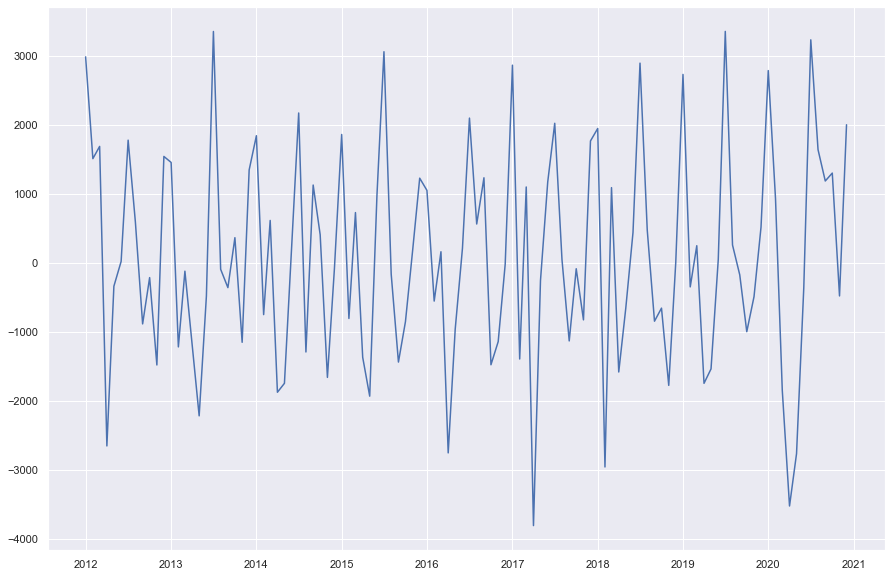

In [92]:
result_mul = seasonal_decompose(df['conso_corr'], model='additive', extrapolate_trend='freq')
detrended = df['conso_corr'] - result_mul.trend
plt.plot(detrended)
plt.show()

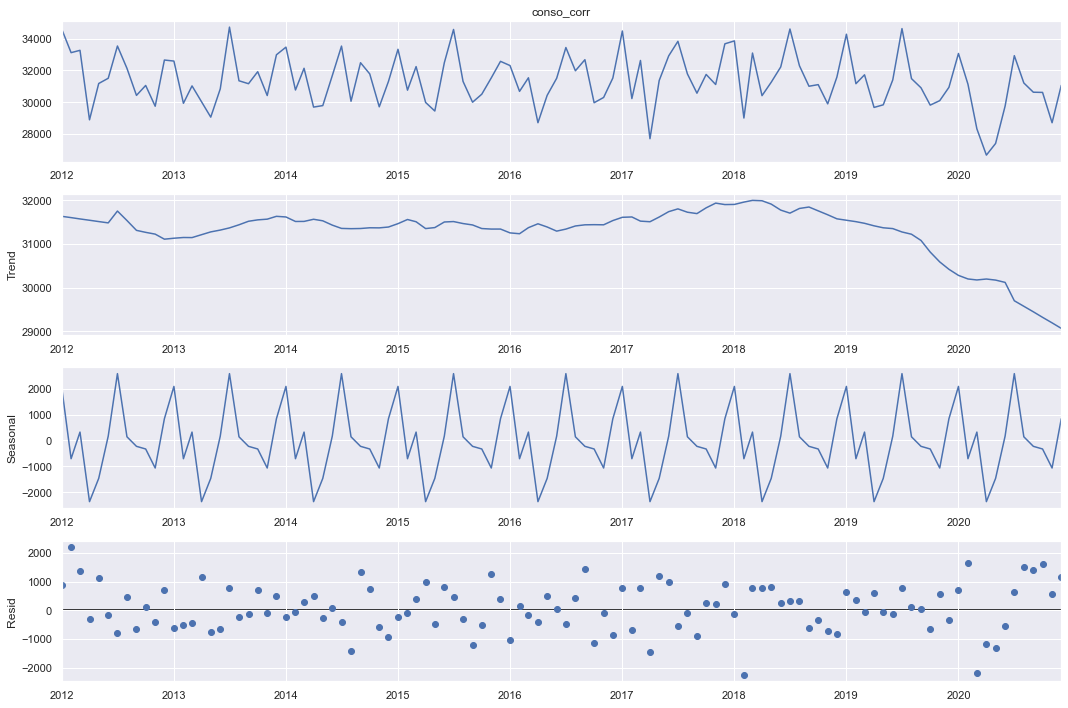

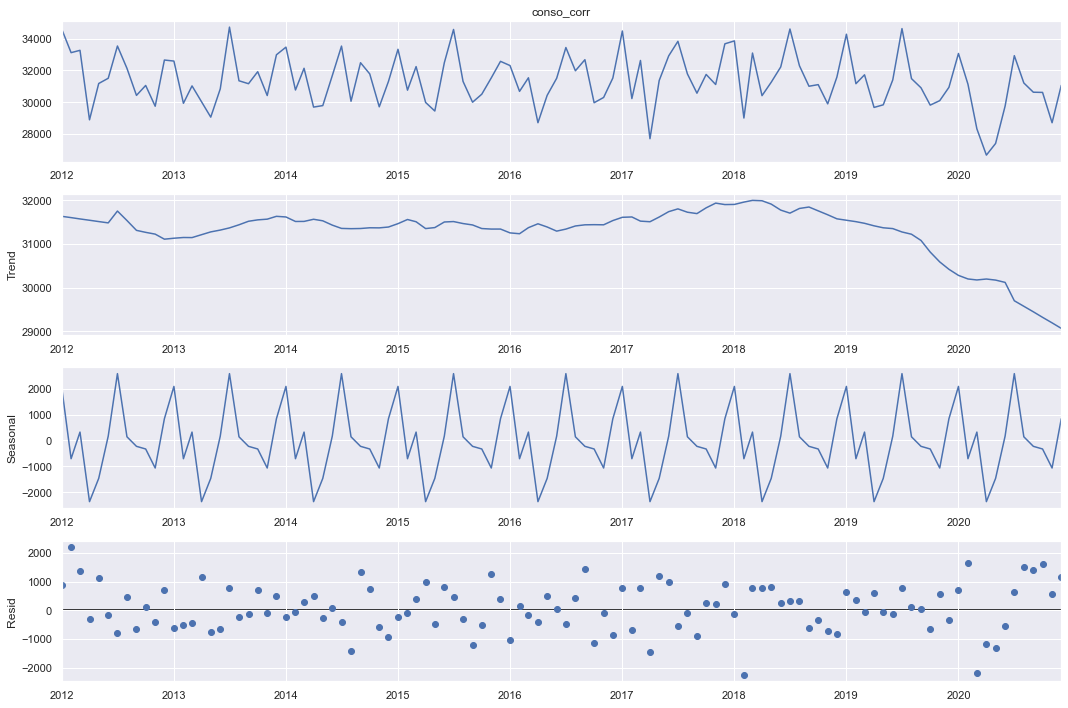

In [93]:
result_mul.plot()

In [94]:
detrended = pd.DataFrame(detrended)

In [95]:
detrended.rename(columns={0:'conso_d'}, inplace=True)

In [96]:
detrended

,conso_d
mois,
2012-01-01,2983.485839
2012-02-01,1508.193727
2012-03-01,1685.700802
2012-04-01,-2655.727454
2012-05-01,-340.663114
...,...
2020-08-01,1638.900503
2020-09-01,1184.512003
2020-10-01,1299.048198


### Tout d'abord, nous devons vérifier si la série temporelle est stationnaire ou non. Nous pouvons le faire grâce au test de Dickey-Fuller.

In [97]:
dv = detrended['conso_d'].values
result = adfuller(dv)

In [98]:
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -5.664003
p-value: 0.000001


### La p-valeur étant supérieur à 5%, nous ne pouvons rejeter H0, à savoir que la série est non-stationnaire. Ainsi, nous devons effectuer une différenciation de la série afin de la rendre stationnaire.

### Récupération de l'ordre de différenciation (d) pour le modèle ARIMA.

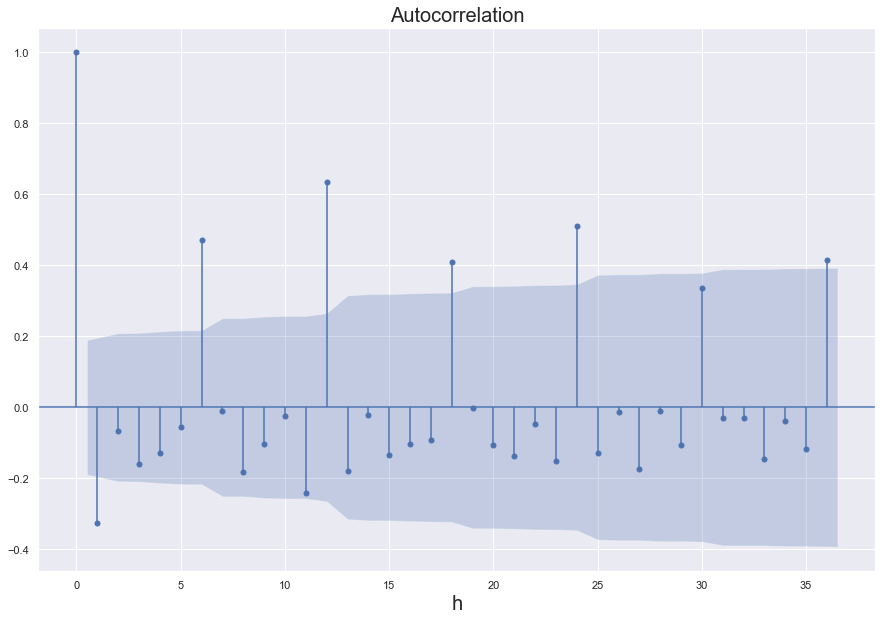

In [99]:
#1ere différenciation
ts = detrended['conso_d'].diff().dropna()
plot_acf(ts, lags=36)
plt.title('Autocorrelation', fontsize=20)
plt.xlabel('h', fontsize=20)
plt.savefig('p9_graphic/auto_1st.png')
plt.show()

### La sortie ACF de la série ainsi différenciée présente encore une décroissance lente vers 0 pour les multiples de 12. On effectue cette fois la différenciation d'ordre 12.

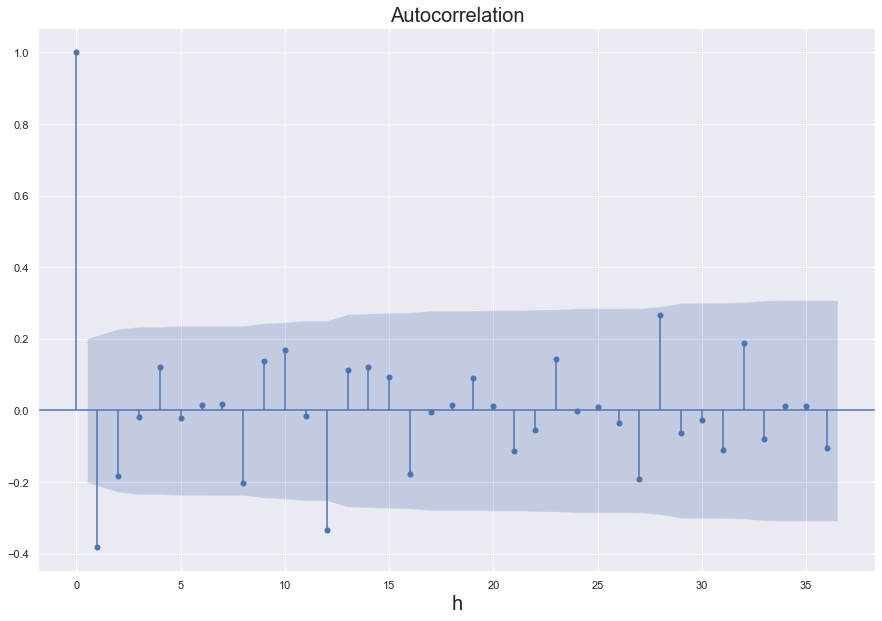

In [100]:
ts_1 = ts.diff(12).dropna()
plot_acf(ts_1, lags=36)
plt.title('Autocorrelation', fontsize=20)
plt.xlabel('h', fontsize=20)
plt.savefig('p9_graphic/auto_2nd.png')
plt.show()

### La sortie ACF est satisfaisante ici, tant elle présente une décroissance rapide vers 0. Nous obtenons ainsi une série stationnaire àprès une différenciation d'ordre 12. Nous pouvons dès à présent passer à la phase d'identification de modèle, c'est-à-dire l'observation des sorties ACF et PACF de la série ainsi différencié pour déduire le modèle potentiel. Ainsi, avec ce graphique, les pics apparaissant plus nets que les autres sont pour h égal à 1 ou 12, nous choisirons donc la valeur de q (MA) égal à 1. 

### Nous allons ensuite afficher la sortie PACF (Partial Autocorrelation) correspondante afin de trouver AR (p).

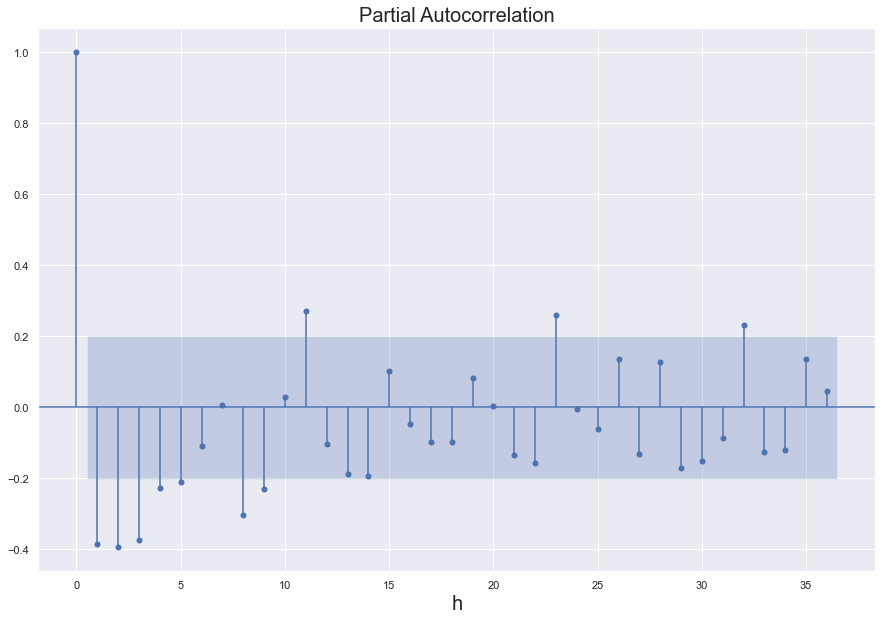

In [102]:
plot_pacf(ts_1, lags=36)
plt.title('Partial Autocorrelation', fontsize=20)
plt.xlabel('h', fontsize=20)
plt.savefig('p9_graphic/pacf.png')
plt.show()

### Ici, nous observons des pics pour h égal à 1, 2 ou 3. Nous choisirons alors p = 1. Nous pouvons alors créer notre modèle SARIMA avec p et q égaux à 1. De plus, nous utiliserons le modèle SARIMA car la série contient une saisonnalité. Il s'agit d'appliquer un modèle ARIMA pour une série saisonnale, avec 3 termes (P, D, Q) qui constituent la partie saisonnière du modèle, et qui seront de même ordre que (p, d, q). Nous obtenons alors le modèle SARIMA suivant:

In [109]:
#Instanciation et entrainement du modèle SARIMA via statsmodels

model = SARIMAX(dv, order=(0,1,1), seasonal_order=(1,1,0,12))
results = model.fit()
print(results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  108
Model:             SARIMAX(0, 1, 1)x(1, 1, [], 12)   Log Likelihood                -800.052
Date:                             Fri, 27 May 2022   AIC                           1606.104
Time:                                     01:18:16   BIC                           1613.766
Sample:                                          0   HQIC                          1609.200
                                             - 108                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9999      0.162     -6.183      0.000      -1.317      -0.683
ar.S.L12      -0.4200      

### Les coefficients sont tous significatifs (p-valeur < 5%), pour que le modèle soit correct, nous allons effectuer un test de blancheur du résidu.

In [110]:
print('Retard : p-value')
for elt in [6, 12, 18, 24, 30, 36]:
    print('{} : {}'.format(elt, acorr_ljungbox(results.resid, lags=elt)[1].mean()))

Retard : p-value
6 : 0.5365306323794224
12 : 0.404088701336835
18 : 0.39382452502036625
24 : 0.43800378401027884
30 : 0.45505438862758946
36 : 0.4304142284713001


C:\Users\denis\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


### Pour chacun des ordres, la p-valeur est toujours supérieure à 5%, l'hypothèse nulle n'est pas rejeté. Ainsi, le résidu suit un bruit blanc, ce qui est correct. Nous allons maintenant tester la normalité du résidu.

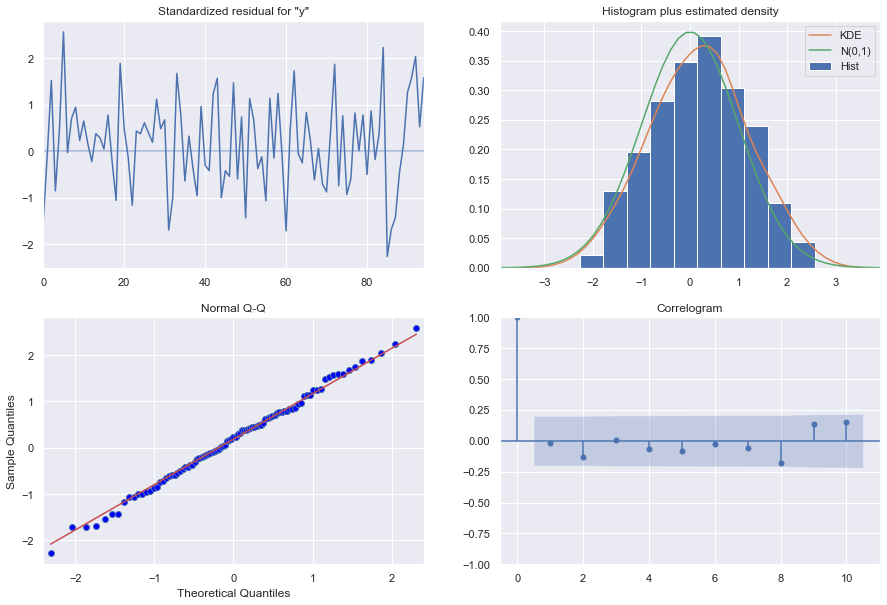

In [111]:
fig = results.plot_diagnostics()

In [114]:
shapiro(results.resid)

ShapiroResult(statistic=0.9852888584136963, pvalue=0.28210392594337463)

### Bien que la p-valeur soit inférieur à 5%, le fait que les résidus est quasiment une distribution gaussienne ne rend pas le modèle absurde.

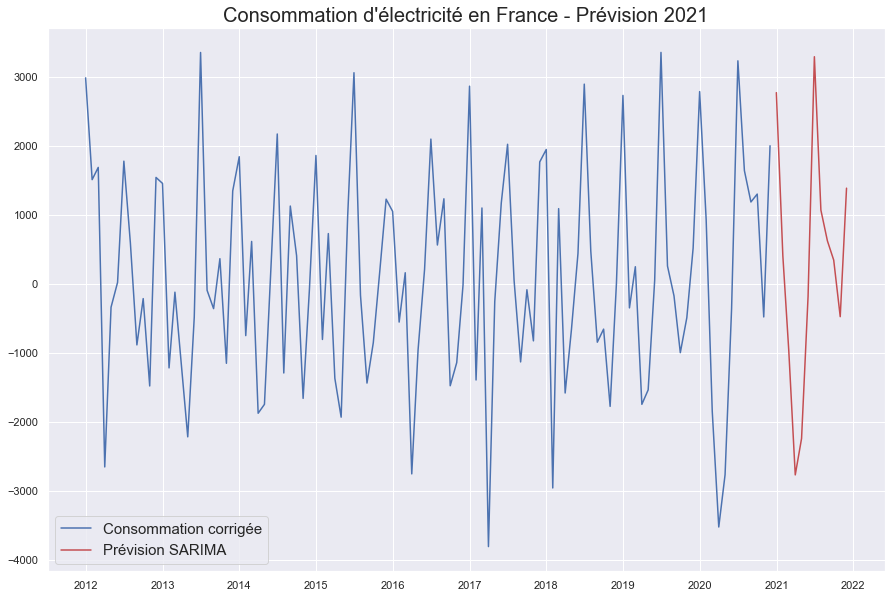

In [115]:
#Visualisation de la prévision à 12 mois par la méthode SARIMA
pred_model = results.get_forecast(12)
pred = pred_model.predicted_mean

plt.plot(detrended['conso_d'], label='Consommation corrigée')
plt.plot(pd.date_range(df.index[len(df)-1], periods=12, freq='M'), pred, color='r', label='Prévision SARIMA')

plt.title("Consommation d'électricité en France - Prévision 2021", fontsize = 20)
plt.legend(fontsize=15)

plt.savefig('p9_graphic/sarima_prevision2021.jpg')
plt.show() 

In [116]:
pred

array([ 2769.44201225,   400.4250519 ,  -961.33416088, -2771.07064935,
       -2243.6769443 ,  -182.71128524,  3289.97799922,  1066.45331281,
         621.05252894,   341.84203886,  -477.77473704,  1384.72858184])

### La prévision par la méthode SARIMA prend en compte la saisonnalité. Nous allons tester ensuite la qualité de prédiction du modèle, en tronquant la série de l'année 2020 que nous allons prédire puis comparer avec les valeurs réelles.

In [250]:
model_tronc = SARIMAX(y, order=(1,1,1), seasonal_order=(1,1,1,12))
results_tronc = model_tronc.fit()
results_tronc.summary()

C:\Users\denis\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\denis\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\denis\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         conso_corr   No. Observations:                   96
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -721.665
Date:                            Thu, 26 May 2022   AIC                           1453.331
Time:                                    06:23:10   BIC                           1465.425
Sample:                                01-01-2012   HQIC                          1458.189
                                     - 12-01-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5579      0.168      3.316      0.001       0.228       0.888
ma.L1         -0.6883      0.163     -4.231      0.000      -1.007      -0.370
ar.S.L12       0.5474      0.070      7.822      0.000       0.410       0.685
ma.S.L12      -1.0000      0.170     -5.885      0.000      -1.333      -0.667
sigma2      1.686e+06   1.01e-07   1.67e+13      0.000    1.69e+06    1.69e+06
===================================================================================
Ljung-Box (L1) (Q):                   6.71   Jarque-Bera (JB):                 0.77
Prob(Q):                              0.01   Prob(JB):                         0.68
Heteroskedasticity (H):               0.92   Skew:                            -0.20
Prob(H) (two-sided):                  0.83   Kurtosis:                         2.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.29e+28. Standard errors may be unstable.
"""

In [239]:
print('Retard : p-value')
for elt in [6, 12, 18, 24, 30, 36]:
    print('{} : {}'.format(elt, acorr_ljungbox(results_tronc.resid, lags=elt)[1].mean()))

Retard : p-value
6 : 0.8650623793109484
12 : 0.8296920509342632
18 : 0.5867592296041998
24 : 0.5222812175960677
30 : 0.5456159108721177
36 : 0.5911016671492786


C:\Users\denis\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


### Les coefficients sont significatifs et le résidu suit un bruit blanc. Le modèle est correct.

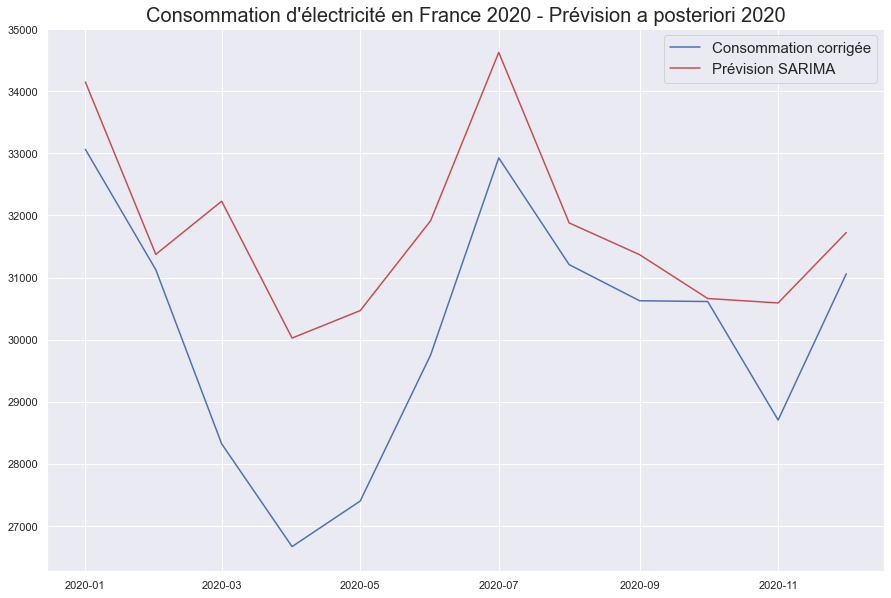

In [243]:
#Visualisation par restriction sur l'année 2020
pred_model_tronc = results_tronc.get_forecast(12)
pred_tronc = pred_model_tronc.predicted_mean

plt.plot(df['conso_corr'].iloc[-12:], label='Consommation corrigée')
plt.plot(df['2020':].index, pred_tronc, color='r', label='Prévision SARIMA')


plt.title("Consommation d'électricité en France 2020 - Prévision a posteriori 2020", fontsize=20)
        
plt.legend(fontsize=15)
plt.savefig("p9_graphic/prevision_visu20182018_sarima_aposteriori.png")
plt.show()

In [244]:
mape = np.mean(np.abs(pred_tronc - (df['2020':]['conso_corr']))/np.abs((df['2020':]['conso_corr'])))*100
mape

5.624271467839321

### Avec un pourcentage d'erreur supérieur à 5%, le modèle SARIMA est moins performant que le modèle Holt-Winters. Ce dernier semble mieux prévoir les évènements imprévus, comme la crise sanitaire de 2020.